# **Data Acquisition and Model Training Report :Artificial Intelligence Project**

This project is a part of the Artificial Intelligence course at Icesi University. This project is developed by:
- Juan David Garzón
- Cristian Perafan
- Geovanny Quintero

# **Neccessary Libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm # Import tqdm for processing bar
tqdm.pandas()
from pathlib import Path # Import Path to handle file paths
from imblearn.under_sampling import RandomUnderSampler
import librosa
import os
import joblib
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

Evaluation metrics

In [2]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

# **Data Loading and Merging**

Valid training data:

In [3]:
valid_train_df = pd.read_csv('../data/cv-valid-train.csv')

Other data:

In [4]:
other_df = pd.read_csv('../data/cv-other-train.csv')

Merging the two datasets:

In [5]:
info_df = pd.concat([valid_train_df, other_df])

Shape of the merged dataset:

In [6]:
info_df.shape

(340911, 8)

In [7]:
info_df.head() 

,filename,text,up_votes,down_votes,age,gender,accent,duration
0,cv-valid-train/sample-000000.mp3,learn to recognize omens and follow them the o...,1,0,NaN,NaN,NaN,NaN
1,cv-valid-train/sample-000001.mp3,everything in the universe evolved he said,1,0,NaN,NaN,NaN,NaN
2,cv-valid-train/sample-000002.mp3,you came so that you could learn about your dr...,1,0,NaN,NaN,NaN,NaN
3,cv-valid-train/sample-000003.mp3,so now i fear nothing because it was those ome...,1,0,NaN,NaN,NaN,NaN
4,cv-valid-train/sample-000004.mp3,if you start your emails with greetings let me...,3,2,NaN,NaN,NaN,NaN


The next step is to assing the target variable to each  audio file path in the dataset. To do this, we will use the next function `load_data` that will return a dataframe with the path of the audio file and the audio file name.

In [8]:
# Function to load the sound data
def load_data():
    file_list = [] # List to store the file paths
    full_list = [] # List to store the labels

    for folder in ['cv-valid-train','cv-other-train']:
        for file in tqdm(Path(f'../data/{folder}').glob('**/*.mp3')):
            # Extract the label from the file path by splitting the path and getting the second last element
            full_path = str(file)
            f_name = full_path.split("\\")[-1]
            file_name = f"{folder}/{f_name}"
            file_list.append(file_name)
            full_list.append(full_path)
       
    df = pd.DataFrame()
    df['filename'] = file_list
    df['file'] = full_list

    return df


Loading the data:

In [9]:
df = load_data()

195776it [00:02, 71374.33it/s] 
145135it [00:02, 50005.50it/s]


Shape of the file information dataframe:

In [10]:
df.shape

(340911, 2)

The next step is merge the dataframe `info_df` that contains the characteristics of the audio files with the dataframe `df` that contains the path of the audio files

In [11]:
df = df.merge(info_df, on='filename', how='inner')

Now we have a dataframe with the file path information and the characteristics of the audio files.

In [12]:
df.head()

,filename,file,text,up_votes,down_votes,age,gender,accent,duration
0,cv-valid-train/sample-000000.mp3,..\data\cv-valid-train\cv-valid-train\sample-0...,learn to recognize omens and follow them the o...,1,0,NaN,NaN,NaN,NaN
1,cv-valid-train/sample-000001.mp3,..\data\cv-valid-train\cv-valid-train\sample-0...,everything in the universe evolved he said,1,0,NaN,NaN,NaN,NaN
2,cv-valid-train/sample-000002.mp3,..\data\cv-valid-train\cv-valid-train\sample-0...,you came so that you could learn about your dr...,1,0,NaN,NaN,NaN,NaN
3,cv-valid-train/sample-000003.mp3,..\data\cv-valid-train\cv-valid-train\sample-0...,so now i fear nothing because it was those ome...,1,0,NaN,NaN,NaN,NaN
4,cv-valid-train/sample-000004.mp3,..\data\cv-valid-train\cv-valid-train\sample-0...,if you start your emails with greetings let me...,3,2,NaN,NaN,NaN,NaN


# **Data preparation**

After having made a first analysis of the data obtained and its nature, it is recognized that the data must go through a preparation process to be used in regression or classification models. This preparation will consist of identifying and dealing with missing data. Since the exportable data analysis found a predominance of data with the accent attribute mainly from the US and England, but also from Australia, India and Canada, samples with accent values will be omitted in order to have a more balanced sample in terms of accent, which is the main focus of this study. 


An important consideration of this project is that the treatment of duplicate data will be omitted due to the specific context of the problem and the audio nature of the data. The omission of duplicate data processing is justified in the context of data of an audio nature because duplication of samples does not necessarily imply redundancy or irrelevance. In audio signal processing, such as speech recognition or music analysis, duplications may represent distinct instances of the same signal, each with characteristics relevant to the analysis. Therefore, preserving duplicate data is crucial for capturing the inherent variability in audio samples and obtaining accurate results in modeling and analysis tasks.

## Missing values processing

In [13]:
df.isnull().sum()

filename           0
file               0
text               2
up_votes           0
down_votes         0
age           203441
gender        203207
accent        221624
duration      340911
dtype: int64

In [14]:
df.isna().sum()

filename           0
file               0
text               2
up_votes           0
down_votes         0
age           203441
gender        203207
accent        221624
duration      340911
dtype: int64

Of the missing values found, the predictor of duration will be discarded because it has no impact on the prediction of accent.

In [15]:
df.drop(columns=['duration'])

,filename,file,text,up_votes,down_votes,age,gender,accent
0,cv-valid-train/sample-000000.mp3,..\data\cv-valid-train\cv-valid-train\sample-0...,learn to recognize omens and follow them the o...,1,0,NaN,NaN,NaN
1,cv-valid-train/sample-000001.mp3,..\data\cv-valid-train\cv-valid-train\sample-0...,everything in the universe evolved he said,1,0,NaN,NaN,NaN
2,cv-valid-train/sample-000002.mp3,..\data\cv-valid-train\cv-valid-train\sample-0...,you came so that you could learn about your dr...,1,0,NaN,NaN,NaN
3,cv-valid-train/sample-000003.mp3,..\data\cv-valid-train\cv-valid-train\sample-0...,so now i fear nothing because it was those ome...,1,0,NaN,NaN,NaN
4,cv-valid-train/sample-000004.mp3,..\data\cv-valid-train\cv-valid-train\sample-0...,if you start your emails with greetings let me...,3,2,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
340906,cv-other-train/sample-145130.mp3,..\data\cv-other-train\cv-other-train\sample-1...,hopefully i didn't just set the voice coding c...,0,0,NaN,NaN,NaN
340907,cv-other-train/sample-145131.mp3,..\data\cv-other-train\cv-other-train\sample-1...,would you like to see where i was tattooed,0,0,NaN,NaN,NaN
340908,cv-other-train/sample-145132.mp3,..\data\cv-other-train\cv-other-train\sample-1...,the cursor blinked expectantly,0,0,fifties,male,england
340909,cv-other-train/sample-145133.mp3,..\data\cv-other-train\cv-other-train\sample-1...,nothing's going to happen,0,0,thirties,male,england


In the same way, the instances that do not have an accent value will be discarded. This is because the accent is our target variable, so any instance without accent cannot be used because it will not be useful to learn from it.

In [16]:
df.dropna(subset=['accent'], inplace=True)
df.reset_index(drop=True, inplace=True)
df.isnull().sum()

filename           0
file               0
text               0
up_votes           0
down_votes         0
age             2445
gender          2197
accent             0
duration      119287
dtype: int64

In [17]:
print(df.columns)

Index(['filename', 'file', 'text', 'up_votes', 'down_votes', 'age', 'gender',
       'accent', 'duration'],
      dtype='object')


In the context of the project to detect and predict accents in audio samples, it faces a remarkable imbalance in the distribution of data between different accents. Although there is an abundance of data from English speakers with accents such as American, British, Indian, Australian, and Canadian, other accents are underrepresented in the dataset. This disparity can introduce biases and affect the ability of the models to generalize effectively. To address this situation, we seek to randomly select an equal sample from each accent, thus ensuring a more balanced distribution of data before proceeding with training the accent prediction models.


The next crucial step in data preprocessing involves addressing missing values through data imputation, using the strategy of replacing missing values with the mean of the corresponding variable. This technique maximizes the amount of valid data available for analysis, thus ensuring a representative and more complete sample for the study.

# **Data Loading and Merging**

In the context of the project to detect and predict accents in audio samples, it faces a remarkable imbalance in the distribution of data between different accents.To address this issue, we will  select the four most commom accents.

In [18]:
from collections import Counter
labels = [lang for lang, _ in Counter(df['accent']).most_common(4)]
print(labels)

['us', 'england', 'indian', 'australia']


The four most common accents are: 'us', 'england', 'indian', 'australia' and 'canada'. Once we have the four most common accents, we will filter the data to only have the samples with these accents.

In [19]:
df = df[df['accent'].isin(labels)]
accent_counts = df['accent'].value_counts()
accent_counts

accent
us           55383
england      28040
indian       10131
australia     7519
Name: count, dtype: int64

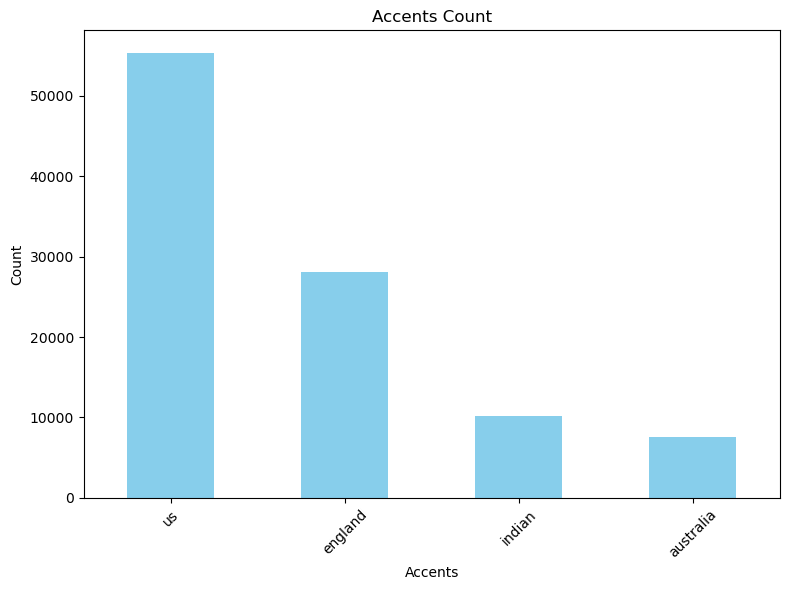

In [20]:
plt.figure(figsize=(8, 6)) 
accent_counts.plot(kind='bar', color='skyblue')

plt.title('Accents Count')
plt.xlabel('Accents')
plt.ylabel('Count')
plt.xticks(rotation=45) 

plt.tight_layout()  
plt.show()

It's possible to see that the data is not balanced, for that razon we have to use a strategy that allows us to subsample the majority class to have the same number of samples as the minority class. This strategy is called undersampling.

`Undersampling`: It is a technique that consists of keeping all the data from the lower frequency class and reducing the amount of data from the higher frequency class, making the set observations have data with the target variable balanced.

In [21]:
random_under_sampler = RandomUnderSampler(random_state=83, sampling_strategy='majority')

# Balancing the dataset
target = df[['accent']]
df = df.drop(columns=['accent'], axis=1)
df, y_resampled = random_under_sampler.fit_resample(df,target)
df['accent'] = y_resampled

In [22]:
accent_counts = df['accent'].value_counts()
accent_counts

accent
england      28040
indian       10131
australia     7519
us            7519
Name: count, dtype: int64

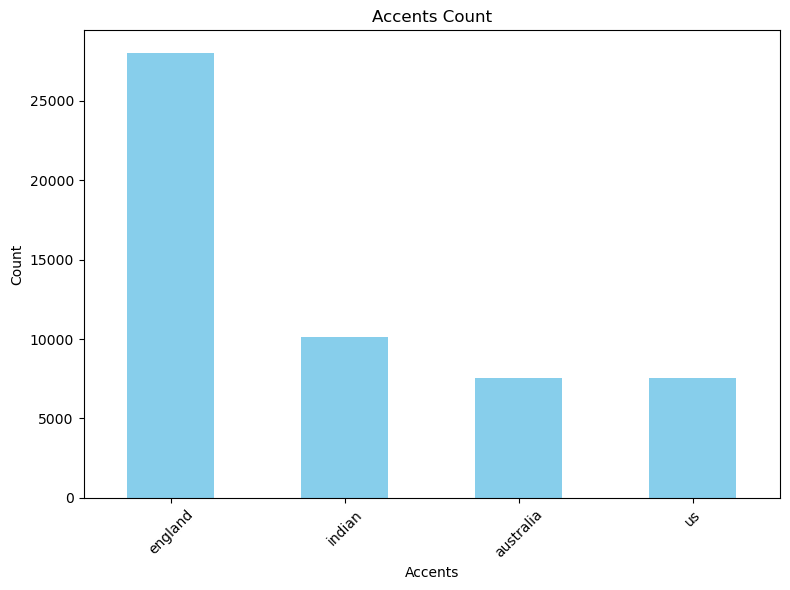

In [23]:
plt.figure(figsize=(8, 6)) 
accent_counts.plot(kind='bar', color='skyblue')

plt.title('Accents Count')
plt.xlabel('Accents')
plt.ylabel('Count')
plt.xticks(rotation=45) 

plt.tight_layout()  
plt.show()

It's possible to see that the data is now balanced, for that razon we have to use a strategy that allows us to subsample the majority class to have similar number of samples as the minority class.

In [24]:
df["accent"] = df["accent"].map({"us": 1, "england": 2, "indian": 3, "australia": 4})

## Audio Processing
The transformation of audio data into a format suitable for machine learning models involves extracting relevant features from the audio signals. This process is known as feature extraction and is essential for capturing the characteristics of the audio samples that are relevant to the prediction of accents. In this project, we will use the Librosa library to extract features from the audio files, which will be used as input to the machine learning models.

In [25]:
RATE_HZ = 16000 # Audios are being sampled at 16,000 times per second

MAX_SECONDS = 1 #  Maximum audio interval length in seconds

MAX_LENGTH = RATE_HZ * MAX_SECONDS # Maximum audio interval length in samples

MIN_RECORDS_PER_LABEL = 25 # Minimum number of records per label

TEST_SIZE = 0.1 # Test set size

In [26]:
def feature_extraction(file):
    features = {}
    audio,_ = librosa.load(file, sr=RATE_HZ)

    spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=audio, sr=RATE_HZ)) # Compute the spectral centroid
    spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=audio, sr=RATE_HZ)) # Compute the spectral bandwidth
    spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(y=audio, sr=RATE_HZ)) # Compute the spectral rolloff
    features['spectral_centroid'] = spectral_centroid
    features['spectral_bandwidth'] = spectral_bandwidth
    features['spectral_rolloff'] = spectral_rolloff
    
    mfcc = librosa.feature.mfcc(y=audio, sr=RATE_HZ) # Compute the mel-frequency cepstral coefficients
    for i, el in enumerate(mfcc):
        features[f'mfcc_{i+1}'] = np.mean(el)
    
    return pd.DataFrame([features])

In [27]:
df.shape

(53209, 9)

Extracting features from audio files involves converting the audio signals into a numerical representation that can be used as input to machine learning models.

In [28]:
import os

absolute_path = os.path.join(os.getcwd(), '../features', 'extracted_features_2.csv')

if os.path.exists(absolute_path):
    print('File exists...')
    df = pd.read_csv(absolute_path)
else :
    print('Extracting features...')
    df_list = list()

    for input_file, input_label in tqdm(zip(df['file'], df['accent'])):
        resulting_df = feature_extraction(input_file)
        if resulting_df is not None:
            resulting_df['accent'] = input_label
            df_list.append(resulting_df)

    df = pd.concat(df_list, axis=0)
    df.to_csv(absolute_path, index=False)


File exists...


In [29]:
df.head()

,spectral_centroid,spectral_bandwidth,spectral_rolloff,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,...,mfcc_12,mfcc_13,mfcc_14,mfcc_15,mfcc_16,mfcc_17,mfcc_18,mfcc_19,mfcc_20,accent
0,1446.691044,1643.481467,2918.068910,-259.87490,122.306564,16.917711,10.219314,13.327199,8.823154,8.225206,...,3.817420,-3.052747,6.017389,-4.560657,2.862503,-3.928597,8.349125,-6.214357,1.375421,australia
1,2187.491472,1719.260458,4048.119029,-207.99960,71.348305,-5.940102,35.687270,8.889826,-10.560427,-19.091818,...,2.461109,-8.039398,-10.819617,-5.266748,-10.238380,-11.084863,2.562678,-8.303602,-3.415712,australia
2,1894.619553,1392.854412,3361.292614,-300.88990,100.381460,-29.792233,35.550663,-10.862653,-23.641230,-1.242105,...,9.834576,-3.892405,-7.340332,-2.482064,-3.793032,-6.573595,-0.230559,-9.262347,-4.456256,australia
3,1926.383326,1575.261555,3578.276210,-237.73344,98.689880,-7.453061,28.496035,-15.077618,-18.470432,-19.584766,...,5.188633,-12.152077,-0.219411,-7.757760,-6.961402,-6.854813,3.746773,-8.498478,7.934193,australia
4,1858.007906,1615.545247,3402.053202,-393.29670,88.668526,10.788974,12.251562,-7.998648,-8.975076,-13.692014,...,-3.105668,-9.158148,0.212392,-10.716672,-2.162414,-5.769405,-5.327674,-4.526900,-6.510139,australia


# **Principal Component Analysis (PCA)**

Principal Component Analysis (PCA) is a dimensionality reduction technique that is widely used in machine learning and data analysis to reduce the number of features in a dataset while preserving the variance of the data. PCA works by transforming the original features into a new set of orthogonal features called principal components, which are linear combinations of the original features. These principal components capture the most significant variations in the data and can be used to reduce the dimensionality of the dataset.


PCA is afected by the scale of the data, so it is important to scale the data before applying PCA. In this project, we will use the StandardScaler from the scikit-learn library to scale the data before applying PCA.

In [30]:
df.columns

Index(['spectral_centroid', 'spectral_bandwidth', 'spectral_rolloff', 'mfcc_1',
       'mfcc_2', 'mfcc_3', 'mfcc_4', 'mfcc_5', 'mfcc_6', 'mfcc_7', 'mfcc_8',
       'mfcc_9', 'mfcc_10', 'mfcc_11', 'mfcc_12', 'mfcc_13', 'mfcc_14',
       'mfcc_15', 'mfcc_16', 'mfcc_17', 'mfcc_18', 'mfcc_19', 'mfcc_20',
       'accent'],
      dtype='object')

Feature to estandarize:

In [31]:
from sklearn.preprocessing import StandardScaler

features = ['spectral_centroid', 'spectral_bandwidth', 'spectral_rolloff', 'mfcc_1',
       'mfcc_2', 'mfcc_3', 'mfcc_4', 'mfcc_5', 'mfcc_6', 'mfcc_7', 'mfcc_8',
       'mfcc_9', 'mfcc_10', 'mfcc_11', 'mfcc_12', 'mfcc_13', 'mfcc_14',
       'mfcc_15', 'mfcc_16', 'mfcc_17', 'mfcc_18', 'mfcc_19', 'mfcc_20']


# Separating out the features
x = df.loc[:, features].values


# Separating out the target
y = df.loc[:,['accent']].values

# Standardizing the features
x = StandardScaler().fit_transform(x)

The original data has 23 features, after applying PCA we will have 2 principal components.

In [32]:
from sklearn.decomposition import PCA


pca = PCA(n_components=2)

principalComponents = pca.fit_transform(x)


principalDf = pd.DataFrame(data = principalComponents, 
                           columns = ['pc_1', 'pc_2'])



Concatenating the principal components with the target variable:

In [33]:
finalDf = pd.concat([principalDf, df[['accent']]], axis = 1)

In [34]:
finalDf.head()

,pc_1,pc_2,accent
0,4.730873,-0.938268,australia
1,-0.503396,0.648694,australia
2,-0.945212,-1.658568,australia
3,-0.580844,-0.339014,australia
4,-0.442645,-0.610531,australia


visualizing the data in a 2D plot:

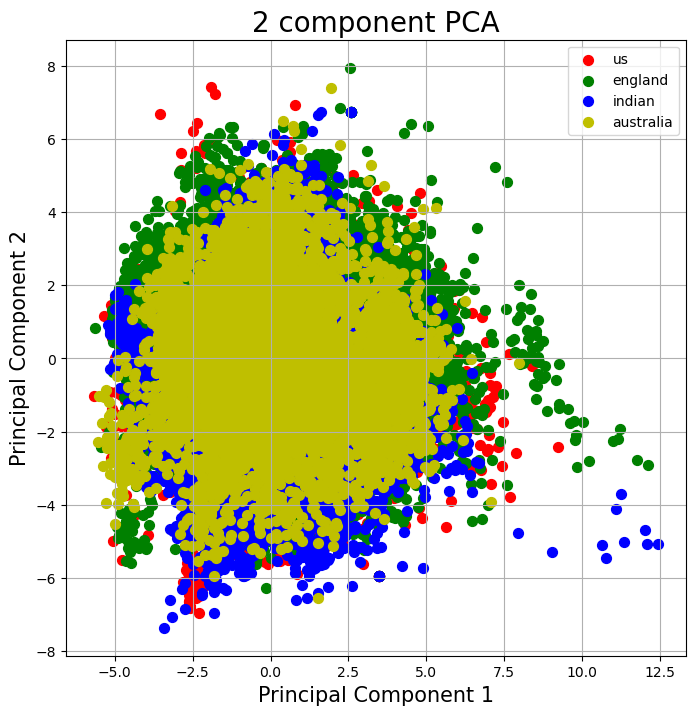

In [35]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)

targets = ['us', 'england', 'indian', 'australia']
colors = ['r', 'g', 'b', 'y']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['accent'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'pc_1']
               , finalDf.loc[indicesToKeep, 'pc_2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

It is possible to see that if we use only two principal components we can't separate the data by accent, so we will use to find the optimal number of components to use in the model.

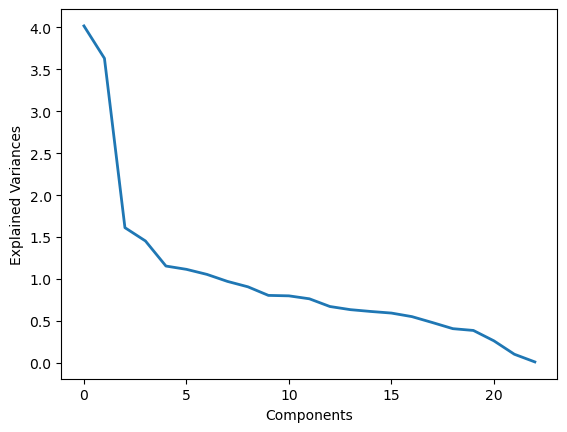

In [36]:
pca = PCA().fit(x)
plt.plot(pca.explained_variance_, linewidth=2)
plt.xlabel('Components')
plt.ylabel('Explained Variances')
plt.show()

In the above plot, we can see that the explained variance ratio starts to decrease after the 10th component. Therefore, we will use 15 components to train the model.

In [37]:
from sklearn.decomposition import PCA

pca = PCA(n_components=15)

principalComponents = pca.fit_transform(x)


principalDf = pd.DataFrame(data = principalComponents, 
                           columns = ['pc_1', 'pc_2', 'pc_3', 'pc_4', 'pc_5', 
                                      'pc_6', 'pc_7', 'pc_8', 'pc_9', 'pc_10', 
                                      'pc_11', 'pc_12', 'pc_13', 'pc_14', 'pc_15'])

Concatenating the principal components with the target variable:

In [38]:
finalDf = pd.concat([principalDf, df[['accent']]], axis = 1)

In [39]:
finalDf.head()

,pc_1,pc_2,pc_3,pc_4,pc_5,pc_6,pc_7,pc_8,pc_9,pc_10,pc_11,pc_12,pc_13,pc_14,pc_15,accent
0,4.730873,-0.938264,0.803289,0.653869,-1.910947,1.060526,0.272591,0.228187,-1.849657,-0.926916,-0.589109,0.078391,-0.344377,-0.606009,-0.219336,australia
1,-0.503401,0.648680,1.019831,-0.003264,-1.622563,-0.075844,-2.555218,0.370910,0.055164,1.070641,0.766827,0.168254,-0.672188,-2.043565,1.112279,australia
2,-0.945219,-1.658580,1.872996,-0.301826,-0.634333,-2.373914,-1.334518,-0.435192,-0.622313,0.597759,0.663406,-1.476097,-0.948407,0.166941,0.185054,australia
3,-0.580839,-0.339014,3.064911,-1.407707,-0.694717,-0.990216,0.845904,2.141459,-0.800165,1.071001,-0.917976,0.446790,-0.766731,0.383237,1.277413,australia
4,-0.442646,-0.610533,-0.991730,0.430035,0.273422,1.425935,0.937276,-0.674120,0.162651,0.925280,-0.308979,-0.963858,0.020746,-0.596849,0.583447,australia


In [40]:
indexed_df=finalDf.reset_index(drop=True, inplace=False)
indexed_df.shape

(53209, 16)

### **Data spliting**

In [41]:
from sklearn.model_selection import train_test_split

X = indexed_df.drop(columns=['accent'])
y = indexed_df['accent']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# **KNN Classifier**

Training data and test data split:

In [42]:
absolute_path = os.path.join(os.getcwd(), '../models', 'knn.pkl')

if os.path.exists(absolute_path):
    print('File exists...')
    grid_search_knn = joblib.load(absolute_path)
else :

    clf = KNeighborsClassifier()

    pipeline = Pipeline([
        ('clf', clf)
    ])

    param_grid = {
        'clf__n_neighbors': [3, 5, 7],      # Number of neighbors to use
        'clf__weights': ['uniform', 'distance'],  # Weight function used in prediction
    }

    grid_search_knn = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1)

    grid_search_knn.fit(X_train, y_train)

    print("Best hyperparameters found:")
    print(grid_search_knn.best_params_)
    best_rdf = grid_search_knn.best_estimator_
    joblib.dump(best_rdf, '../models/knn.pkl')

Best hyperparameters found:
{'clf__n_neighbors': 3, 'clf__weights': 'distance'}


Metrics:

In [43]:
y_pred = grid_search_knn.predict(X_test)

In [44]:
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'Precision: {precision_score(y_test, y_pred, average=None)}')
print(f'Recall: {recall_score(y_test, y_pred, average=None)}')
print(f'F1: {f1_score(y_test, y_pred, average=None)}')

Accuracy: 0.8603645931215936
Precision: [0.83957553 0.87631272 0.86068111 0.80326383]
Recall: [0.86662371 0.94516361 0.84030227 0.57420609]
F1: [0.85288523 0.9094369  0.85036962 0.6696901 ]


# **Random Forest Classifier**

In [45]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()



absolute_path = os.path.join(os.getcwd(), '../models', 'randomForest.pkl')

if os.path.exists(absolute_path):
    print('File exists...')
    grid_search_rdf = joblib.load(absolute_path)
else :

    # Definir el pipeline con un paso de escalamiento (si es necesario) y el clasificador
    pipeline = Pipeline([
        ('scaler', StandardScaler()),  # Escalar los datos si es necesario
        ('clf', clf)
    ])

    # Definir los parámetros que deseas ajustar
    param_grid = {
        'clf__n_estimators': [10, 50, 100],  # Número de árboles en el bosque
        'clf__max_depth': [None, 10, 20],      # Profundidad máxima de cada árbol
    }

    # Realizar la búsqueda de la cuadrícula utilizando GridSearchCV
    grid_search_rdf = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1)

    # Ajustar el modelo a los datos de entrenamiento
    grid_search_rdf.fit(X_train, y_train)

    # Mostrar los mejores hiperparámetros encontrados
    print("Mejores hiperparámetros encontrados:")
    print(grid_search_rdf.best_params_)

    best_rdf = grid_search_rdf.best_estimator_
    joblib.dump(best_rdf, '../models/randomForest.pkl')

Mejores hiperparámetros encontrados:
{'clf__max_depth': None, 'clf__n_estimators': 100}


Metrics:

In [46]:
y_pred = grid_search_rdf.predict(X_test)

print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'Precision: {precision_score(y_test, y_pred, average=None)}')
print(f'Recall: {recall_score(y_test, y_pred, average=None)}')
print(f'F1: {f1_score(y_test, y_pred, average=None)}')

Accuracy: 0.7519263296372862
Precision: [0.96237172 0.71084337 0.80628571 0.84168865]
Recall: [0.54381443 0.97590795 0.71083123 0.20674012]
F1: [0.69493619 0.82254887 0.75555556 0.33194589]


# Deployment Plan

In an increasingly interconnected world, effective communication has become an invaluable skill. In the realm of the English language, where a wide variety of accents and dialects coexist, understanding and adapting to different ways of speaking are essential for successful communication. With the aim of facilitating this process of understanding and adaptation, the "Neutral Accent" project has been developed, an educational application that seeks to help users approximate a more neutral accent in the English language. 

### Objectives
The main objective of deploying "Neutral Accent" is to make available to the public an interactive educational application that facilitates improvement in English pronunciation and approximation to a more neutral accent. Techniques of artificial intelligence and audio signal processing will be utilized to analyze and classify the accents present in audio files.

### Feasibility
The deployment of the project is based on the availability of artificial intelligence and audio signal processing technologies, as well as access to high-quality training data. There is a growing demand for educational applications that help improve English pronunciation, which supports the feasibility of the project. However, it will face competition in the market of educational and language learning applications.

### Scalability
The "Neutral Accent" project is designed to be scalable, allowing for horizontal expansion of its architecture to encompass a large number of users. Measures will be implemented to ensure that the application can handle an increase in the number of users without compromising its performance.

### Niche
The target audience of "Neutral Accent" includes users seeking to improve their English pronunciation for academic, professional, or personal purposes, as well as educational institutions wishing to incorporate language learning tools into their curriculum. Additionally, professionals working in international environments who wish to enhance their communication skills in English may benefit from this application.

### Security Implications
The deployment of "Neutral Accent" will require security measures to protect users' personal and sensitive data, such as audio files and registration data. Security protocols will be implemented, and regulations and data privacy standards, such as GDPR and CCPA, will be complied with to ensure the protection of users' privacy.

### Ethical Implications
Special attention will be given to the ethical implications of the "Neutral Accent" project. Accuracy and impartiality in accent classification will be ensured to avoid discriminatory biases. Furthermore, users' privacy and rights in handling their personal data will be respected, and constructive and positive feedback will be provided to foster learning and personal development. Linguistic and cultural diversity will be promoted, and the stigmatization of certain accents or dialects will be avoided at all stages of the application's development and deployment.